## Exportando múltiplas imagens para o Drive

#### Este exemplo apresenta como exportar múltiplas imagens geradas pelo modelo ssebop para o Drive

### Importando a biblioteca Google Earth Engine

In [6]:
try:
    import ee 
except:
    !pip install earthengine-api
    import ee

### Importando a biblioteca geemap

In [7]:
try:
    import geemap
except:
    !pip install geemap
    !pip install pycrs
    import geemap

In [2]:
# Instalando bibliotecas secundárias do OpenET

# Installing openet-core package
# https://github.com/Open-ET/openet-core

#    !pip install openet-core

# Installing openet.refetgee package
# https://github.com/Open-ET/openet-refet-gee

#    !pip install openet-refet-gee

### Inicializando Google Eaeth Engine
#### Necessário definir o projeto_id a ser utilizado

In [8]:
project_id = 'et-brasil'

try:
    ee.Initialize(project=project_id)
except:
    ee.Authenticate()

### Importando o modelo e definido a localização do ambiente de trabalho 

In [ ]:
import pprint
import sys
import datetime
import pandas as pd
from IPython.display import Image

# Escolha o modelo:
model_name = 'ssebop'
sys.path.append(f'C:\openet_brazil\workshop_et_models\openet-{model_name}')

if model_name == 'ssebop':
    import openet.ssebop as model
elif model_name == 'geesebal':
    import openet.geesebal as model
elif model_name == 'ptjpl':
    import openet.ptjpl as model

### Variáveis

In [ ]:
collections = ['LANDSAT/LC08/C02/T1_L2','LANDSAT/LE07/C02/T1_L2']
meteorology_source_inst='ECMWF/ERA5_LAND/HOURLY'
meteorology_source_daily='projects/openet/assets/meteorology/era5land/sa/daily'
et_reference_source = 'projects/et-brasil/assets/era5/daily/etr'
et_reference_band = 'eto24h'
et_reference_factor = 1.0
et_reference_resample = 'nearest'
et_reference_date_type = 'daily'


# Período de análise
start_date = '2018-06-01'
end_date = '2018-08-01'

# Cobertura de nuvens
cloud_cover = 70

# Paleta de cores
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']
lst_palette = ['blue','green','yellow','orange','red']

# Tamanho da imagem para a visualização
image_size = 768

### Lendo o shapefile e transformando em objeto GEE utilizando geemap

In [11]:
# Shapefile
shp_file = 'geometria/geometria_exemplo.shp'

# Convertendo para objeto GEE (Feature Collection)
geom = geemap.shp_to_ee(shp_file)

# Visualizando
Map = geemap.Map()
Map.addLayer(geom, {}, "area")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Criando o objeto do modelo

In [ ]:
# Build the SSEBop object from the Landsat image
if model_name == 'ssebop':
    model_obj = model.Collection(
        collections=collections,
        et_reference_source=et_reference_source, 
        et_reference_band=et_reference_band,
        et_reference_factor=et_reference_factor,
        et_reference_resample=et_reference_resample,
        et_reference_date_type=et_reference_date_type,
        start_date=start_date,
        end_date=end_date,
        geometry=geom,
        cloud_cover_max=cloud_cover)

# Build the geeSEBAL   object from the Landsat image
if model_name == 'geesebal':

    model_obj = model.Collection(
        collections=collections,
        start_date=start_date,
        end_date=end_date,
        geometry=geom,
        cloud_cover_max=cloud_cover,
        model_args={
                    'meteorology_source_inst': meteorology_source_inst,
                    'meteorology_source_daily': meteorology_source_daily,
                    'et_reference_source': et_reference_source,
                    'et_reference_band': et_reference_band,
                    'et_reference_factor': et_reference_factor,
                    'et_reference_resample': et_reference_resample},) 
    
# Build the PT-JPL   object from the Landsat image
if model_name == 'ptjpl':
    model_obj = model.Collection(
        collections=collections,
        start_date=start_date,
        end_date=end_date,
        geometry=geom,
        cloud_cover_max=cloud_cover,
        model_args={
                    'et_reference_source': et_reference_source, 
                    'et_reference_band': et_reference_band,
                    'et_reference_factor': et_reference_factor,
                    'et_reference_resample': et_reference_resample,
            },
                    
                )

len(model_obj.get_image_ids())

16

### Criando uma classe com os resultados de et, ndbi, etr e etf

In [13]:
overpass_coll = model_obj.overpass(variables=['ndvi', 'et', 'et_reference', 'et_fraction'])

### Visualizando a média das imagens 

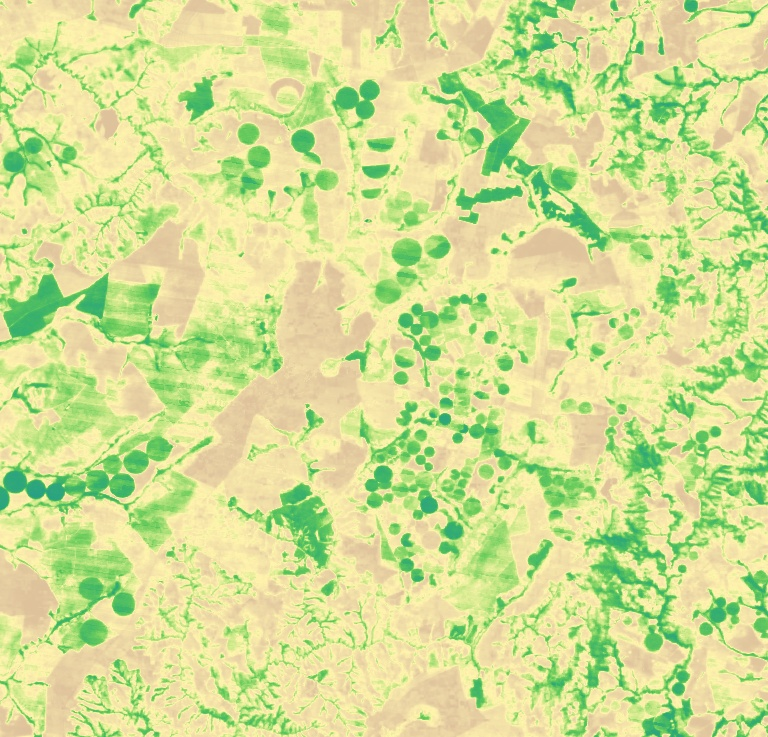

In [14]:
image_url = overpass_coll.mean().select('et')\
    .getThumbURL({'min': 0.0, 'max': 5, 'palette': et_palette, 
                  'region': geom.geometry() , 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Exportando cada imagem através de um loop


In [15]:

list_files = model_obj.get_image_ids()

for file_name in list_files:

    print(f'Exportando imagem: {file_name}')

    image = overpass_coll.filter(ee.Filter.eq('image_id',file_name)).first()

    landsat_scene = file_name.split('/')[4]

    bands = ['et','ndvi','et_fraction']


    task = ee.batch.Export.image.toDrive(
        image=image.select(bands),
        description=landsat_scene,
        folder='workshop_ana',
        scale = 30,
        region  = geom.geometry()
    )

    task.start()

Exportando imagem: LANDSAT/LC08/C02/T1_L2/LC08_220072_20180602
Exportando imagem: LANDSAT/LC08/C02/T1_L2/LC08_220072_20180618
Exportando imagem: LANDSAT/LC08/C02/T1_L2/LC08_220072_20180704
Exportando imagem: LANDSAT/LC08/C02/T1_L2/LC08_220072_20180720
Exportando imagem: LANDSAT/LC08/C02/T1_L2/LC08_221072_20180609
Exportando imagem: LANDSAT/LC08/C02/T1_L2/LC08_221072_20180625
Exportando imagem: LANDSAT/LC08/C02/T1_L2/LC08_221072_20180711
Exportando imagem: LANDSAT/LC08/C02/T1_L2/LC08_221072_20180727
Exportando imagem: LANDSAT/LE07/C02/T1_L2/LE07_220072_20180610
Exportando imagem: LANDSAT/LE07/C02/T1_L2/LE07_220072_20180626
Exportando imagem: LANDSAT/LE07/C02/T1_L2/LE07_220072_20180712
Exportando imagem: LANDSAT/LE07/C02/T1_L2/LE07_220072_20180728
Exportando imagem: LANDSAT/LE07/C02/T1_L2/LE07_221072_20180601
Exportando imagem: LANDSAT/LE07/C02/T1_L2/LE07_221072_20180617
Exportando imagem: LANDSAT/LE07/C02/T1_L2/LE07_221072_20180703
Exportando imagem: LANDSAT/LE07/C02/T1_L2/LE07_221072_2